# Solving SAT Through Python Libraries

## Things We Are Going To Implement

1. Graph 3-coloring
   - Brute-force method
   - Backtracking (using recursion)
   - SAT solvers
2. Graph $k$-coloring (Exercise)
3. Hamiltonian Path
   - SAT solvers
   - Backtracking (Exercise)
4. Sudoku Solver (Exercise)

In [1]:
import pycosat as sat
import networkx as nx
from random import random
from itertools import product, combinations

## Graph 3-Colouring

### Creating some test graphs
1. $G_1$: An odd-cycle
2. $G_2$: Peterson Graph
3. $G_3$: A random tripartite graph
4. $G_4$: Adding a few intra-part edges to $G_3$ 

The first 3 are YES instances for 3-coloring, while the 4th is most likely a NO instance


In [2]:
G1 = nx.cycle_graph(11)

In [3]:
G2 = nx.petersen_graph()

In [10]:
# Generate a random 3-colorable graph
n = 100
p = 0.2

G3 = nx.empty_graph()

for u, v in combinations(range(n), 2):
    if (u - v) % 3 != 0 and random() < p:
        G3.add_edge(u, v)

G3.number_of_nodes(), G3.number_of_edges()

(100, 648)

In [11]:
p_in = 0.001

G4 = G3.copy()

for u, v in combinations(range(n), 2):
    if (u - v) % 3 == 0 and random() < p_in:
        G4.add_edge(u, v)

G4.number_of_nodes(), G4.number_of_edges()

(100, 649)

### Helper Functions

In [12]:
# A function to check if a given coloring is proper

def is_proper(G, col_dict):
    # Function to check if a given coloring is proper
    if G.number_of_nodes() != len(col_dict):
        return False

    for u, v in G.edges():
        if col_dict[u] == col_dict[v]:
            return False
    return True

In [14]:
# A function to draw a graph in circular layout with nodes grouped by colors
def draw_color(G, col_dict):
    nodes_by_color = sorted(col_dict, key=col_dict.get)
    C = nx.cycle_graph(nodes_by_color)
    pos = nx.circular_layout(C)
    col_list = [col_dict[node] for node in G.nodes()]
    nx.draw_networkx(G, pos=pos, node_color=col_list,
                     with_labels=False, node_size=3000/G.number_of_nodes())

### 3-Colouring by Brute Force

In [15]:
def color_brute(G, n_colors):
    colors = range(n_colors)
    for coloring in product(colors, repeat=G.number_of_nodes()):
        if is_proper(G, coloring):
            return dict(zip(G.nodes(), coloring))
    return dict()

Coloring returned is proper.


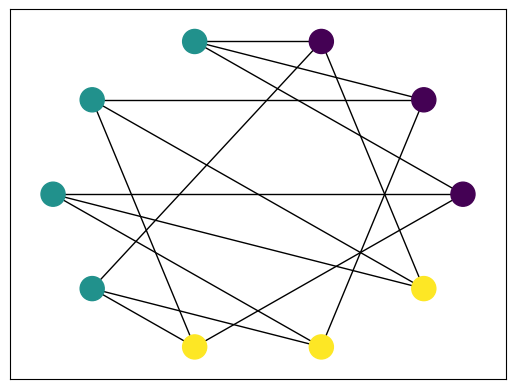

In [16]:
# Testing
G = G2
col_dict = color_brute(G, 3)
if is_proper(G, col_dict):
    print("Coloring returned is proper.")
    draw_color(G, col_dict)
else:
    print("Coloring returned is NOT proper.")

In [17]:
%timeit -n2 -r 5 color_brute(G, 3)

11.4 ms ± 6.93 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


### 3-Colouring Using Backtracking

In [18]:
def color_backtrack(G, n_colors):
    colors = set(range(n_colors))
    col_dict = {node: -1 for node in G.nodes()}
    if _color_backtrack(G, colors, col_dict):
        return col_dict
    else:
        return dict()


def _color_backtrack(G, colors, col_dict) -> bool:
    for node, col in col_dict.items():
        if col == -1:
            v = node
            break
    else:
        return True

    nbr_cols = set(col_dict[u] for u in G[v])
    free_cols = colors - nbr_cols

    if (len(free_cols) == 0):
        return False

    for c in free_cols:
        col_dict[v] = c
        if _color_backtrack(G, colors, col_dict):
            return True

    col_dict[v] = -1  # Backtracking
    return False

Coloring returned is proper.


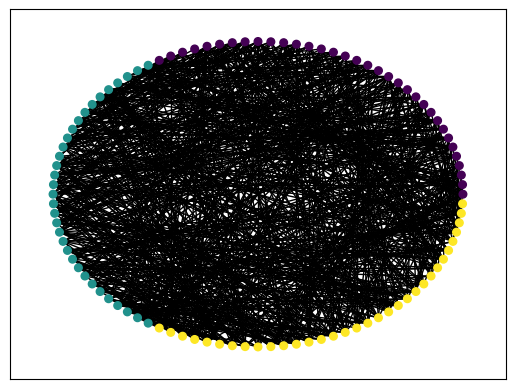

In [19]:
# Testing
G = G3
col_dict = color_backtrack(G, 3)
if is_proper(G, col_dict):
    print("Coloring returned is proper.")
    draw_color(G, col_dict)
else:
    print("Coloring returned is NOT proper.")

In [20]:
%timeit -n2 -r 5 color_backtrack(G3, 3)

The slowest run took 4.52 times longer than the fastest. This could mean that an intermediate result is being cached.
7.48 ms ± 4.7 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)


### Example Of SAT Solver

In [21]:
# Example cnf = (x v y) ^ (x v -y) ^ (-x v y)
# x, -x = 1, -1
# y, -y = 2, -2

cnf = [
    [+1, +2],
    [+1, -2],
    [-1, +2]]

sat.solve(cnf)

[1, 2]

### 3-coloring using SAT solver

Problem: We have to find a proper vertex color of a graph $G$ using colors $C = \{1, 2, 3\}$

**Variables:**
-  For each $v \in V(G)$ and $c \in C$, $x_{v, c}$ is `True` iff node $v$ has color $c$

**Picosat representation of literals:**
- Nodes are integers from $0$ to $n = |V(G)|$
- Colors are integers from $1$ to $c$
- Literal $x_{v,i}$ is represented by the number $+(3*v + i)$
- Literal $\neg x_{v,i}$ is represented by the number $-(3*v + i)$

**Constraints**
- No two adjacent nodes get the same color
- Every node gets at least one color

In [22]:
# Translators

# Variables
def var(node, color):
    assert node >= 0
    assert 0 <= color < 3
    return 3*node + color + 1

# A node u gets at least one color


def is_colored(u):
    clauses = [[var(u, 0), var(u, 1), var(u, 2)]]
    return clauses

# Nodes u and v get the differnt color


def diff_color(u, v):
    clauses = [
        [-var(u, 0), -var(v, 0)],
        [-var(u, 1), -var(v, 1)],
        [-var(u, 2), -var(v, 2)]]
    return clauses

# Helper function to convert the SAT solution to a colour dictionary


def sol_to_col(sol):
    n = len(sol)//3
    col_dict = dict()
    for i in range(n):
        col_dict[i] = max(sol[3*i:3*i+3]) - 3*i - 1  # Ugly
    return col_dict

In [23]:
def three_color_sat(G):
    cnf = []

    # Every node gets at least one color
    for u in G.nodes():
        cnf += is_colored(u)

    # All pairs of adjacent nodes get the diffent color
    for u, v in G.edges():
        cnf += diff_color(u, v)

    # Solve cnf using SAT solver
    sol = sat.solve(cnf)

    # Convert solution to a colour dictionary
    if sol == 'UNSAT':
        return dict()
    else:
        return sol_to_col(sol)

Coloring returned is proper.


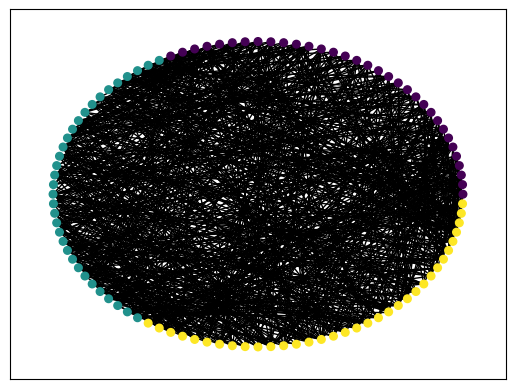

In [24]:
# Testing
G = G3
col_dict = three_color_sat(G)
if is_proper(G, col_dict):
    print("Coloring returned is proper.")
    draw_color(G, col_dict)
else:
    print("Coloring returned is NOT proper.")

In [25]:
%timeit -n2 -r 5 color_backtrack(G3, 3)
%timeit -n2 -r 5 three_color_sat(G3)

%timeit -n2 -r 5 color_backtrack(G4, 3)
%timeit -n2 -r 5 three_color_sat(G4)

7.76 ms ± 4.41 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)
The slowest run took 4.18 times longer than the fastest. This could mean that an intermediate result is being cached.
1.84 ms ± 1.33 ms per loop (mean ± std. dev. of 5 runs, 2 loops each)
19.4 ms ± 67.3 µs per loop (mean ± std. dev. of 5 runs, 2 loops each)
1.2 ms ± 70.7 µs per loop (mean ± std. dev. of 5 runs, 2 loops each)


## Graph K-Colouring